In [3]:
import json
from langdetect import detect

with open('/data_train/search/zengziyang/projects/RAG-Retrieval/examples/short-sighted_pitfalls/exp3.jsonl') as f:
    data = [json.loads(line) for line in f]

In [3]:
data[0]

{'query': None,
 'pos': 'ADHD a \'brain disorder\', not just bad behaviour: study\n16 Feb 2017 - 9:01\nParis: People with ADHD have slightly smaller brains than those without the condition, according to a study released Thursday which insisted it is a physical disorder and not just bad behaviour.\nThe largest analysis to date of the brains of people with attention deficit hyperactivity disorder found "structural differences" and evidence of delayed development compared with non-sufferers, researchers reported.\n"The results from our study confirm that people with ADHD have differences in their brain structure and therefore suggest that ADHD is a disorder of the brain," said the study\'s lead author, Martine Hoogman of Radboud University Medical Centre in the Netherlands.\n"We hope that this will help to reduce stigma that ADHD is \'just a label\' for difficult children or caused by poor parenting," she said in a statement.\nThe results of the study, which involved 1,713 people with ADH

In [4]:
data[0].keys()

dict_keys(['query', 'pos', 'neg_list', 'src', 'lang', 'extra', 'summary', 'qa'])

In [5]:
model_set = set()
for d in data:
    model_set.add(d['qa']["model_name"])
            
model_set = list(model_set)
print(model_set)

['GLM-4-Plus', 'gpt-4o-mini', 'deepseek-v3', 'meta-llama/Llama-3.3-70B-Instruct', 'Qwen/Qwen2.5-72B-Instruct', 'GLM-4-Air-0111', 'Llama-3.3-70B-Instruct-Q4_K_M.gguf', 'gemini-1.5-flash-002', 'deepseek-r1', 'deepseek-chat', 'deepseek-ai/DeepSeek-V3']


In [6]:
adict = {}
for d in data:
    if "summary" not in d:
        continue
    adict[d['summary']["model_name"]] = adict.get(d['summary']["model_name"], 0) + 1

sorted_adict = dict(sorted(adict.items(), key=lambda item: item[1], reverse=True))
sorted_adict

{'gpt-4o-mini': 10232,
 'qwen2.5:72b-instruct-q8_0': 7256,
 'GLM-4-Flash': 6708,
 'gemini-1.5-flash-002': 4960,
 'Qwen/Qwen2.5-32B-Instruct': 2700,
 'Qwen/Qwen2.5-72B-Instruct': 1880,
 'deepseek-chat': 1338}

In [8]:
adict = {}
for d in data:
    adict[d['qa']["model_name"]] = adict.get(d['qa']["model_name"], 0) + 1

sorted_adict = dict(sorted(adict.items(), key=lambda item: item[1], reverse=True))
sorted_adict

{'gpt-4o-mini': 11309,
 'deepseek-ai/DeepSeek-V3': 9095,
 'meta-llama/Llama-3.3-70B-Instruct': 9089,
 'gemini-1.5-flash-002': 7172,
 'Llama-3.3-70B-Instruct-Q4_K_M.gguf': 5152,
 'GLM-4-Plus': 3738,
 'GLM-4-Air-0111': 3518,
 'Qwen/Qwen2.5-72B-Instruct': 2709,
 'deepseek-chat': 1338,
 'deepseek-v3': 527,
 'deepseek-r1': 38}

In [9]:
adict = {}
key = "src"
for d in data:
    adict[d[key]] = adict.get(d[key], 0) + 1

sorted_adict = dict(sorted(adict.items(), key=lambda item: item[1], reverse=True))
sorted_adict

{'fineweb_edu': 20454,
 'infinity_instruct': 17809,
 'sbert_TriviaQA_pairs': 10006,
 'sbert_gooaq_pairs': 1304,
 'sbert_PAQ_pairs': 1273,
 'sbert_msmarco_triplets': 1243,
 'sbert_eli5_question_answer': 1030,
 'sbert_NQ': 566}

In [10]:
adict = {}
key = "lang"
for d in data:
    adict[d[key]] = adict.get(d[key], 0) + 1

sorted_adict = dict(sorted(adict.items(), key=lambda item: item[1], reverse=True))
sorted_adict

{'en': 53685}

In [70]:
data[0]

{'query': None,
 'pos': 'ADHD a \'brain disorder\', not just bad behaviour: study\n16 Feb 2017 - 9:01\nParis: People with ADHD have slightly smaller brains than those without the condition, according to a study released Thursday which insisted it is a physical disorder and not just bad behaviour.\nThe largest analysis to date of the brains of people with attention deficit hyperactivity disorder found "structural differences" and evidence of delayed development compared with non-sufferers, researchers reported.\n"The results from our study confirm that people with ADHD have differences in their brain structure and therefore suggest that ADHD is a disorder of the brain," said the study\'s lead author, Martine Hoogman of Radboud University Medical Centre in the Netherlands.\n"We hope that this will help to reduce stigma that ADHD is \'just a label\' for difficult children or caused by poor parenting," she said in a statement.\nThe results of the study, which involved 1,713 people with ADH

In [20]:
alist = []
black_list = ["GLM-4-Plus", "GLM-4-Air-0111"]
import tqdm


for d in tqdm.tqdm(data):
    passage = d["pos"]
    src = d["src"]
    summary = d.get("summary", {})
    
    if d['qa']["model_name"] in black_list:
        continue
    for idx, r_list in enumerate(d['qa']["result"]):
        if r_list is None:
            continue
        for r_ in r_list:
            if isinstance(r_, str):
                continue
            if 'question' not in r_:
                continue
            question = r_['question']
            answer = r_['answer'] if 'answer' in r_ else None
            question_level = r_['type'] if 'type' in r_ else None
            if 3 > len(question.split(" ")):
                continue
            if detect(question) != 'en':
                continue
            alist.append({
                "question": question,
                "content": passage,
                "content_src": src,
                "content_summary": summary,
                "answer": answer,
                "question_level": question_level,
                "span": d['qa']['result_span'][idx] if d['qa']['result_span'] is not None else None,
                "qa_model": d['qa']["model_name"]   
            })
            
with open('/data_train/search/zengziyang/projects/RAG-Retrieval/examples/short-sighted_pitfalls/exp3_qp.jsonl', 'w') as f:
    for item in alist:
        f.write(json.dumps(item, ensure_ascii=False) + '\n')

100%|██████████| 53685/53685 [21:57<00:00, 40.76it/s]


In [4]:
with open("/data_train/search/zengziyang/projects/RAG-Retrieval/examples/short-sighted_pitfalls/exp3_qp.jsonl") as f:
    data = [json.loads(line) for line in f]

print(len(data) / 503845) 

# data2 = [ d for d in data1 if 3 <= len(d["question"].split(" ")) <= 50 and 500 <= len(d["content"].split(" "))]

0.5279917434925423


In [97]:
data[0]

{'question': 'What does the name Glendalough mean and where is it located?',
 'content': "[Sunday - 11/17/02] The name of this magnificent monastic site originates from the Irish “Gleann da locha,” meaning “the valley of the two lakes.” Indeed, this rings true as Glendalough is found 46 km south of Dublin in County Wicklow, where the River Glenealo feeds into the River Glendasan, just downstream from what are know as the Upper and Lower lakes. Just before this junction is the main group of ruins referred to as the Monastic City. Glendalough was founded as a hermitage by St. Kevin in the latter part of the 6th century A.D. While his royal lineage is generally accepted, most tales of Kevin’s life are confused by myth and embellishment. But by the time of Kevin’s death in 618, a monastery was firmly established that would function through the 15th century and serve as a place of pilgrimage up through present day.\nGlendalough has been historically plagued by recurring misfortune. The ruin

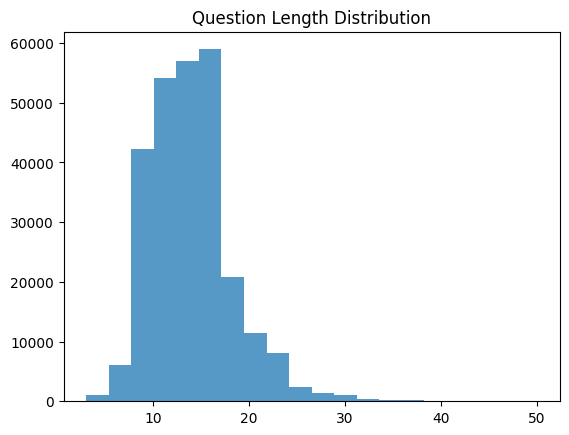

In [71]:
query_set = set()
for d in data:
    query_set.add(d['question'])
query_len = [len(q.split(" ")) for q in query_set]
query_len.sort()
# 画出频率分布直方图

import matplotlib.pyplot as plt
import numpy as np

plt.hist(query_len, bins=20, alpha=0.75)
plt.title('Question Length Distribution')
plt.show()

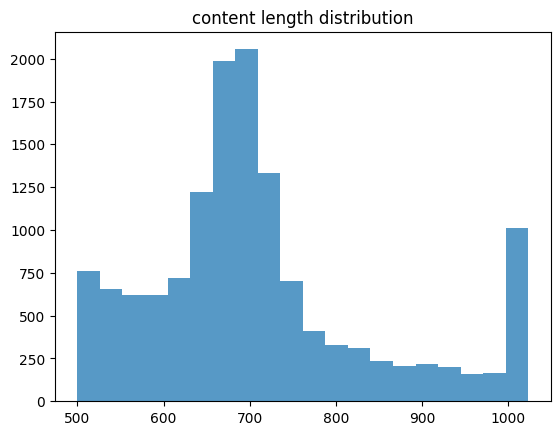

In [70]:
content_set = set()
for d in data:
    content_set.add(d['content'])
content_len = [len(q.split(" ")) for q in content_set]
content_len.sort()
# 画出频率分布直方图

import matplotlib.pyplot as plt
import numpy as np

plt.hist(content_len[:], bins=20, alpha=0.75)
plt.title('content length distribution')
plt.show()

In [58]:
len(query_set), len(content_set)

(265568, 13927)

In [83]:
def classify_span(z, m, n):
    """
    分类 span (m, n) 在 z 个单词的段落中的位置。
    若跨区段，则归入后面的段落。
    
    参数：
    z -- 段落的总单词数
    m -- span 起始索引
    n -- span 结束索引
    
    返回：
    一个字符串，表示分类结果（'前段', '中段', '后段'）。
    """
    third = z // 3  # 计算每个段落的界限
    
    if n < third:  # 完全在前段
        return ["before"]
    elif m >= third and n < 2 * third:  # 完全在中段
        return ["middle"]
    elif m >= 2 * third:  # 完全在后段
        return ["after"]
    elif n < 2 * third:  # 跨前-中，归中段
        # return "middle"
        return ["before", "middle"]
    else:  # 跨中-后，归后段
        # return "after"
        return ["middle", "after"]

In [84]:
classify_span(len(data[0]["content"].split()), data[0]["span"][0], data[0]["span"][0])

['before']

In [85]:
for d in data:
    d["span_class"] = classify_span(len(d["content"].split()), d["span"][0], d["span"][1])

In [92]:
span_classes = []
for d in data:
    for i in d["span_class"]:
        span_classes.append(i)
from collections import Counter
Counter(span_classes)

Counter({'middle': 199893, 'after': 160993, 'before': 103844})

In [93]:
data[0]

{'question': 'What does the name Glendalough mean and where is it located?',
 'content': "[Sunday - 11/17/02] The name of this magnificent monastic site originates from the Irish “Gleann da locha,” meaning “the valley of the two lakes.” Indeed, this rings true as Glendalough is found 46 km south of Dublin in County Wicklow, where the River Glenealo feeds into the River Glendasan, just downstream from what are know as the Upper and Lower lakes. Just before this junction is the main group of ruins referred to as the Monastic City. Glendalough was founded as a hermitage by St. Kevin in the latter part of the 6th century A.D. While his royal lineage is generally accepted, most tales of Kevin’s life are confused by myth and embellishment. But by the time of Kevin’s death in 618, a monastery was firmly established that would function through the 15th century and serve as a place of pilgrimage up through present day.\nGlendalough has been historically plagued by recurring misfortune. The ruin

In [94]:
with open('/data_train/search/zengziyang/projects/RAG-Retrieval/examples/short-sighted_pitfalls/exp3_qp.jsonl', 'w') as f:
    for item in data:
        f.write(json.dumps(item, ensure_ascii=False) + '\n')

In [95]:
len(data)

266026

In [61]:
adict = {}
key = "content_src"
for d in data:
    adict[d[key]] = adict.get(d[key], 0) + 1

sorted_adict = dict(sorted(adict.items(), key=lambda item: item[1], reverse=True))
sorted_adict

{'sbert_TriviaQA_pairs': 143457,
 'fineweb_edu': 112307,
 'infinity_instruct': 10155,
 'sbert_NQ': 107}

In [62]:
adict = {}
key = "question_level"
for d in data:
    adict[d[key]] = adict.get(d[key], 0) + 1

sorted_adict = dict(sorted(adict.items(), key=lambda item: item[1], reverse=True))
sorted_adict

{'complicated': 181876,
 'simple': 84079,
 None: 65,
 'complex': 4,
 '-complicated': 2}

In [69]:
adict = {}
alist = []
key = "span"
max_span = []
for d in data:
    d["span"] = d["span"] if d["span"] is not None else []
    alist.append(d["span"])
alist.sort(key=lambda x: x[1], reverse=True)
alist

[[1120, 1201],
 [1120, 1201],
 [1120, 1201],
 [1120, 1201],
 [1120, 1197],
 [1120, 1197],
 [1120, 1197],
 [1120, 1197],
 [896, 1153],
 [896, 1153],
 [896, 1153],
 [896, 1153],
 [896, 1153],
 [896, 1152],
 [896, 1152],
 [896, 1152],
 [896, 1152],
 [896, 1152],
 [896, 1152],
 [896, 1152],
 [896, 1152],
 [896, 1152],
 [896, 1152],
 [896, 1145],
 [896, 1145],
 [896, 1145],
 [896, 1145],
 [896, 1145],
 [896, 1144],
 [896, 1144],
 [896, 1144],
 [896, 1144],
 [896, 1144],
 [896, 1144],
 [896, 1143],
 [896, 1143],
 [896, 1143],
 [896, 1143],
 [896, 1140],
 [896, 1140],
 [896, 1140],
 [896, 1140],
 [896, 1140],
 [896, 1140],
 [896, 1140],
 [896, 1140],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139],
 [896, 1139]

In [98]:
data[0]

{'question': 'What does the name Glendalough mean and where is it located?',
 'content': "[Sunday - 11/17/02] The name of this magnificent monastic site originates from the Irish “Gleann da locha,” meaning “the valley of the two lakes.” Indeed, this rings true as Glendalough is found 46 km south of Dublin in County Wicklow, where the River Glenealo feeds into the River Glendasan, just downstream from what are know as the Upper and Lower lakes. Just before this junction is the main group of ruins referred to as the Monastic City. Glendalough was founded as a hermitage by St. Kevin in the latter part of the 6th century A.D. While his royal lineage is generally accepted, most tales of Kevin’s life are confused by myth and embellishment. But by the time of Kevin’s death in 618, a monastery was firmly established that would function through the 15th century and serve as a place of pilgrimage up through present day.\nGlendalough has been historically plagued by recurring misfortune. The ruin

In [5]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# with open('/data_train/search/zengziyang/projects/RAG-Retrieval/examples/short-sighted_pitfalls/exp3_qp_train.jsonl', 'w') as f:
#     for item in train_data:
#         f.write(json.dumps(item, ensure_ascii=False) + '\n')

# with open('/data_train/search/zengziyang/projects/RAG-Retrieval/examples/short-sighted_pitfalls/exp3_qp_test.jsonl', 'w') as f:
#     for item in test_data:
#         f.write(json.dumps(item, ensure_ascii=False) + '\n')

In [39]:
with open("/data_train/search/zengziyang/projects/RAG-Retrieval/examples/short-sighted_pitfalls/exp3_qp_train.jsonl") as f:
    train_data = [json.loads(line) for line in f]

with open("/data_train/search/zengziyang/projects/RAG-Retrieval/examples/short-sighted_pitfalls/exp3_qp_test.jsonl") as f:
    test_data = [json.loads(line) for line in f]

len(train_data), len(test_data)

(228120, 37745)

In [40]:
with open("/data_train/search/zengziyang/projects/RAG-Retrieval/examples/short-sighted_pitfalls/exp3_qp_all.jsonl") as f:
    data = [json.loads(line) for line in f]

len(data) == len(train_data) + len(test_data)

True

In [ ]:
import polars as pl
import tqdm

text_list = []
parquet_data = pl.read_parquet("/processing_data/search/zengziyang/data/fineweb-edu/000_00000.parquet").rows(named=True)
for document in tqdm.tqdm(parquet_data):
    if 512 <= len(document["text"].split()) <= 2048:
        text_list.append(document["text"])

print(len(text_list))
preprocessed_texts = [(t, len(t.split())) for t in text_list]

100%|██████████| 726000/726000 [00:26<00:00, 27621.13it/s]

296707


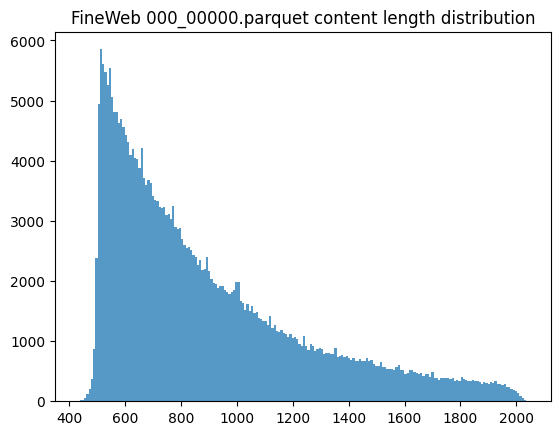

In [ ]:
text_lengt = [len(t.split(" ")) for t in text_list]

import matplotlib.pyplot as plt
import numpy as np

plt.hist(text_lengt, bins=200, alpha=0.75)
plt.title('FineWeb 000_00000.parquet content length distribution')
plt.show()

In [25]:
import random

def pad_content_with_samples(
    content,
    preprocessed_texts,
    target_len=8000,
    mode=None,
    allow_truncate=True,
):
    """
    拼接文本，使总长度接近 target_len（按单词数），支持三种拼接方式。
    本版本不再分句，而是直接使用整个文本块，同时确保同一文本块不会重复使用。

    Args:
        content (str): 原始文本内容。
        preprocessed_texts (List[Tuple[str, int]]): 已处理好的 (text, word_count) 对。
        target_len (int): 目标总词数。
        mode (str|None): 'both', 'before', 'after' 三种拼接方式，None 则随机选择。
        allow_truncate (bool): 是否允许截断最后一个片段以填满目标长度。

    Returns:
        str: 拼接好的文本字符串。
    """
    content_words = content.split()
    content_len = len(content_words)
    remaining_len = target_len - content_len
    if remaining_len <= 0:
        return content

    if mode not in {"both", "before", "after"}:
        mode = random.choice(["both", "before", "after"])

    # 用于去重文本块
    used_texts = set()

    def collect_samples(target_words):
        total = 0
        samples = []
        for text, count in preprocessed_texts:
            if text in used_texts:
                continue

            # 如果整个文本块加入后不会超过目标词数，则直接添加
            if total + count <= target_words:
                samples.append(text)
                total += count
                used_texts.add(text)
            # 如果允许截断且当前总词数不足，则截取部分单词
            elif allow_truncate and total < target_words:
                take = target_words - total
                words = text.split()
                partial = ' '.join(words[:take])
                samples.append(partial)
                total += take
                break

            if total >= target_words:
                break
        return samples

    if mode == "both":
        left_len = remaining_len // 2
        right_len = remaining_len - left_len
        left_samples = collect_samples(left_len)
        right_samples = collect_samples(right_len)
        final_parts = left_samples + [content] + right_samples
    elif mode == "before":
        before_samples = collect_samples(remaining_len)
        final_parts = before_samples + [content]
    else:  # mode == "after"
        after_samples = collect_samples(remaining_len)
        final_parts = [content] + after_samples

    return "\n".join(final_parts)

In [ ]:
# 假设你有一个原始 content 和一个 text list
content = "This is the main content that is between 500 and 1000 words long."


In [ ]:
content = pad_content_with_samples(content, preprocessed_texts)
print(len(content.split()))

8000


In [8]:
import json
with open("exp3_8K_passages_before.json") as f:
    a = f.readlines()

In [10]:
a[0]

'"A Date Which Will Live in Infamy": FDR Asks for a Declaration of War talking history | syllabi | students | teachers | puzzle | about us “A Date Which Will Live in Infamy”: FDR Asks for a Declaration of War The Japanese attack on Pearl Harbor, Hawaii, on December 7, 1941, stunned virtually everyone in the United States military. Japan’s carrier-launched bombers found Pearl Harbor totally unprepared. President Franklin Roosevelt quickly addressed Congress to ask for a declaration of war as illustrated in this audio excerpt. Although he never mentioned Europe or the fact that Germany had not yet declared war on the United States, the Pearl Harbor attack allowed him to begin the larger intervention in the European war he had long wanted. Listen to Audio: Your browser is unable to play the audio element. Try updating to the latest version of your browser. President Franklin D. Roosevelt: Yesterday, December 7, 1941—a date which will live in infamy—the United States of America was suddenl

In [1]:
import json
with open("/data_train/search/zengziyang/projects/RAG-Retrieval/examples/short-sighted_pitfalls/exp3_8K_passages_after.json") as f:
   passages = json.loads(f.read())

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("/processing_data/search/zengziyang/models/nvidia/NV-Embed-v2")

In [4]:
import multiprocessing

with multiprocessing.Pool() as pool:
    passage_lens = [len(ids["input_ids"]) for ids in pool.map(tokenizer, passages)]
print(passage_lens)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[11260, 11360, 11458, 11329, 11297, 11478, 11595, 11383, 11355, 11394, 11470, 11420, 11358, 11455, 11553, 11365, 11424, 11383, 11380, 11394, 11394, 11346, 11379, 11443, 11327, 11297, 11307, 11393, 11513, 11378, 11401, 11352, 11520, 11475, 11384, 11396, 11443, 11526, 11348, 11417, 11379, 11415, 11461, 11362, 11491, 11852, 11378, 11330, 11308, 11407, 11377, 11421, 11346, 11354, 11359, 11422, 11223, 11876, 11767, 11369, 13893, 11440, 11361, 11424, 11346, 11624, 11379, 11384, 11442, 11380, 11756, 11468, 11414, 11423, 11386, 11436, 11403, 11379, 11393, 11364, 11361, 11340, 11434, 11388, 11391, 11291, 11368, 11375, 11432, 11446, 11283, 11364, 11396, 11523, 11344, 11489, 11305, 11358, 11496, 11495, 11339, 11324, 11345, 11502, 11474, 11342, 11345, 11281, 11317, 11341, 11444, 11347, 11392, 11440, 11347, 11316, 11558, 11379, 11329, 11394, 11647, 11383, 11672, 11316, 11429, 11135, 11529, 11458, 11210, 11375, 11578, 11583, 11482, 11283, 11399, 11302, 11387, 11628, 11313, 11410, 11398, 11355, 11367

In [7]:
min(passage_lens), max(passage_lens)

(11062, 13893)

In [25]:
with open("/data_train/search/zengziyang/projects/RAG-Retrieval/examples/short-sighted_pitfalls/exp3_qp_all.jsonl") as f:
    all_data = [json.loads(line) for line in f]

In [26]:
passage_set = {d["content"] for d in all_data}
passage_lens = {p: len(tokenizer(p)["input_ids"]) for p in passage_set}
len(passage_lens) # 原始：13927

13902

In [30]:
count = dict()
for d in all_data:
    count[d["content"]] = count.get(d["content"], 0) + 1

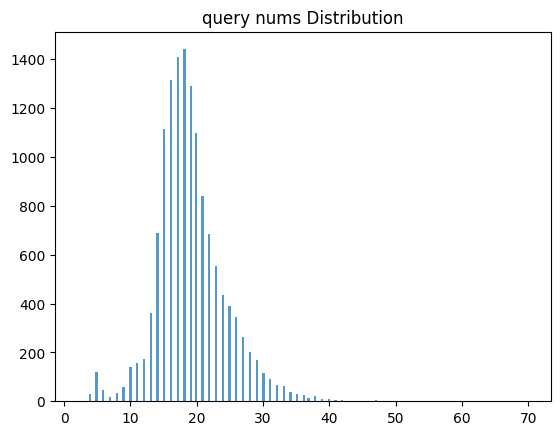

In [35]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(count.values(), bins=200, alpha=0.75)
plt.title('query nums Distribution')
plt.show()

In [36]:
import random
passage_set_2000 = random.sample(passage_set, 2000)

test_data = [d for d in all_data if d["content"] in passage_set_2000]
train_data = [d for d in all_data if d["content"] not in passage_set_2000]

/tmp/ipykernel_78458/3819775236.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  passage_set_2000 = random.sample(passage_set, 2000)


In [ ]:
# with open('/data_train/search/zengziyang/projects/RAG-Retrieval/examples/short-sighted_pitfalls/exp3_qp_train.jsonl', 'w') as f:
#     for item in train_data:
#         f.write(json.dumps(item, ensure_ascii=False) + '\n')

# with open('/data_train/search/zengziyang/projects/RAG-Retrieval/examples/short-sighted_pitfalls/exp3_qp_test.jsonl', 'w') as f:
#     for item in test_data:
#         f.write(json.dumps(item, ensure_ascii=False) + '\n')

In [37]:
len(test_data), len(train_data)

(37745, 228120)

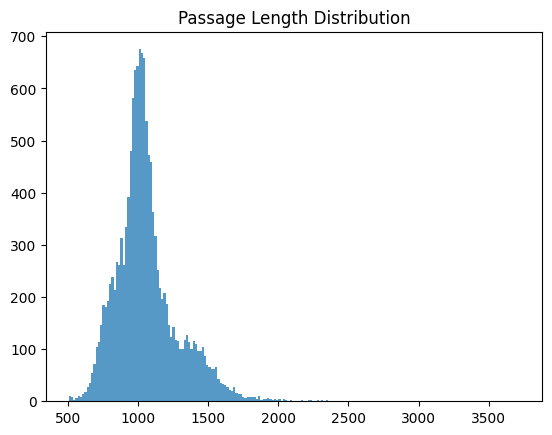

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(passage_lens.values(), bins=200, alpha=0.75)
plt.title('Passage Length Distribution')
plt.show()

In [23]:
new_data = []
for d in all_data:
    if passage_lens[d["content"]] >= 500:
        new_data.append(d)
        
len(new_data), len(all_data)

(265865, 266026)